# Soluciones a la ecuación de Mathieu

La ecuación de Mathieu es de la forma 

$$\displaystyle \frac{d^2 \chi_k}{dT^2} + \left[ A_k - 2q \cos(2T) \right] \chi_k = 0 \tag{1}$$

dónde $A_k$ y $q$ son los parámetros de la resonancia paramétrica y van a estar dados por

$$q = \frac{g^2}{4} \left( \frac{\phi_0}{m} \right)^2; \hspace{3cm} A_k = \left( \frac{k}{m} \right)^2 + 2 q; \hspace{3cm} T = m t + \frac{\pi}{2} \tag{2}$$

dónde $g$ es la constante de acoplamiento entre el campo del inflatón $\phi$ y el campo hijo $\chi$, $m$ es la masa del campo hijo, $\phi_0$ es el valor inicial del campo inflatón y $k$ es el valor del número de onda del modo que queremos ver cómo evoluciona para el campo hijo.

El campo del inflatón planteamos que es de la forma 

$$\phi (t) = \phi_0 \cos (mt) \tag{3}$$

que sale de resolver la ecuación 

$$\ddot{\phi} + \frac{\partial V}{\partial \phi} = 0 \tag{4}$$

para un potencial armónico de la forma

$$V(\phi) = \frac{1}{2} m^2 \phi^2 \tag{5}$$

## Librerías

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import solve_ivp

mpl.rc('figure', figsize=(12, 6))
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('font', size = '14')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)

# Funciones

A partir de la ecuación (1) podemos definir una función de primer orden que pueda resolver numéricamente la ecuación de Mathieu, para hacer ésto podemos definir $u = \chi_k$ y $\displaystyle v = \frac{d \chi}{dT}$ podemos escribir la ecuación de Mathieu como el siguiente sistema de ecuaciones:

$$\begin{cases}
    u^\prime &= v\\
    v^\prime &= - \left[ A_k - 2q \cos(2T) \right] \chi_k
\end{cases} \tag{6}$$

dónde el primado es la derivada respecto $T$.

La ecuación de Mathieu (1) tiene por solución algo de la forma

$$\chi_k = \mathcal{M}^{(+)}_k (T) ~ e^{\mu_k T} + \mathcal{M}^{(-)}_k (T) ~ e^{- \mu_k T} \tag{7}$$

siendo $\mu_k$ los coeficientes de Floquet. Para calcular estos coeficientes, se puede seguir un algoritmo como el que describe [arXiv:1410.3808] en la sección 3, la idea general es obtener la matriz 

$$\mathcal{O}(t_0 + T, t_0) = \begin{pmatrix}
    u^{(1)} (t_0 + T) & u^{(2)} (t_0 + T)\\
    v^{(1)} (t_0 + T) & v^{(2)} (t_0 + T)\\
\end{pmatrix} \tag{8}$$

dónde el supraíndice $(1),(2)$ indica cuando consideramos como condiciones iniciales (1,0) y (0,1) para $u$ y $v$. Entonces, este coeficiente lo podemos calcular como

$$\mu = \frac{1}{T} \cosh^{-1} \left[ \frac{\text{Tr} \left( \mathcal{O} \right)}{2} \right] \tag{9}$$

notemos que si la traza es menor que 2 tendremos un valor real para $\mu$ mientras que si la traza es mayor que 2 tendremos un valor imaginario para $\mu$.

In [12]:
# Ecuación de Mathieu
def mathieu(t, y, A_k, q):
    u, v = y
    du_dt = v
    dv_dt = - (A_k - 2 * q * np.cos(2 * t)) * u
    return [du_dt, dv_dt]

# Coeficientes de Floquet
def floquet_coeff(A, q):
    T = np.pi                                                                       # Periodo de la función coseno (recordar que tenemos cos(2T))
    sol1 = solve_ivp(mathieu, [0, T], [1, 0], args=(A, q), rtol=1e-8, atol=1e-8)
    y1, y1_prime = sol1.y[0][-1], sol1.y[1][-1]

    sol2 = solve_ivp(mathieu, [0, T], [0, 1], args=(A, q), rtol=1e-8, atol=1e-8)
    y2, y2_prime = sol2.y[0][-1], sol2.y[1][-1]

    M = np.array([[y1, y2], [y1_prime, y2_prime]])
    Delta = np.trace(M)

    if abs(Delta) > 2:
        mu_real = np.arccosh(abs(Delta)/2) / T
        mu_imag = 0
    else:
        mu_real = 0
        mu_imag = np.arccos(Delta/2) / T
    mu = mu_real + 1j * mu_imag
    return mu

# Guardar los resultados en una matriz con Ak en las filas, q en las columnas y mu en las celdas
def save_csv(Aks, qs, mu, filename='results'):
    # Parte real
    output_real = np.zeros((len(Aks)+1, len(qs)+1))
    output_real[0, 1:] = qs
    output_real[1:, 0] = Aks
    output_real[1:, 1:] = np.real(mu)
    np.savetxt(f"{filename}_real.csv", output_real, delimiter=",")
    
    # Parte imaginaria
    output_imag = np.zeros((len(Aks)+1, len(qs)+1))
    output_imag[0, 1:] = qs
    output_imag[1:, 0] = Aks
    output_imag[1:, 1:] = np.imag(mu)
    np.savetxt(f"{filename}_imag.csv", output_imag, delimiter=",")

## Tabla de inestabilidades de Mathieu

Primero tomemos $A_k \in (0, 15)$ y $q \in (0,5)$ para replicar la figura 20 de $\textit{Cosmic Inflation: Background dynamics, Quantum fluctuations and}$ $\textit{Reheating}$ de Swagat S. Mishra.

In [3]:
qs = np.linspace(0, 5, 200)
Aks = np.linspace(0, 15, 200)
q, Ak = np.meshgrid(qs, Aks)
mu = np.zeros((len(Aks), len(qs)), dtype=complex)

for i in range(len(Aks)):
    for j in range(len(qs)):
        mu[i, j] = floquet_coeff(Aks[i], qs[j])

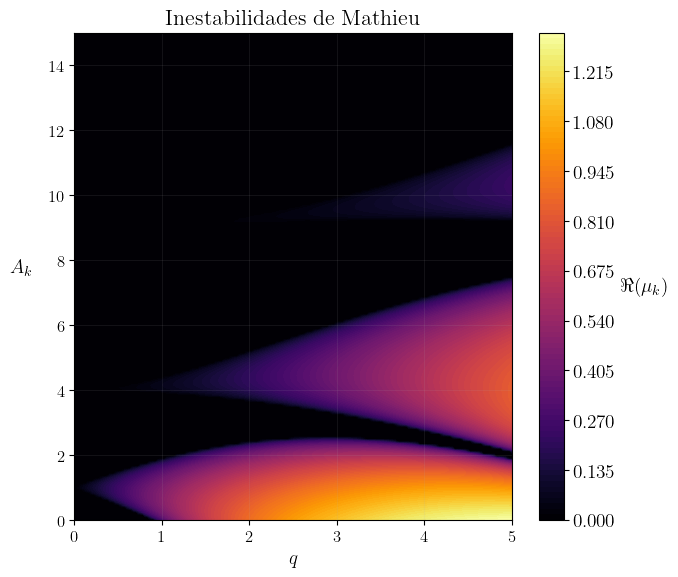

In [4]:
plt.figure(figsize=(7, 6))
contour = plt.contourf(q, Ak, np.real(mu), levels=100, cmap='inferno')
cbar = plt.colorbar(contour)
cbar.set_label(r'$\Re(\mu_k)$', fontsize=14, labelpad=20, rotation=0)

plt.title(r'Inestabilidades de Mathieu', fontsize=16)
plt.xlabel(r'$q$', fontsize=14)
plt.ylabel(r'$A_k$', fontsize=14, labelpad=20, rotation=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha = 0.1)
plt.tight_layout()
plt.show()

In [5]:
# Guardemos los resultados en un archivo CSV
save_csv(Aks, qs, mu, filename='mathieu_results1')

Ahora extendamos este gráfico a $A_k \in (0, 100)$ y $q \in (0,200)$ para ver cómo son las bandas en valores más grandes de $q$ y $A_k$

In [6]:
qs = np.linspace(0, 200, 200)
Aks = np.linspace(0, 100, 200)
q, Ak = np.meshgrid(qs, Aks)
mu = np.zeros((len(Aks), len(qs)), dtype=complex)

for i in range(len(Aks)):
    for j in range(len(qs)):
        mu[i, j] = floquet_coeff(Aks[i], qs[j])

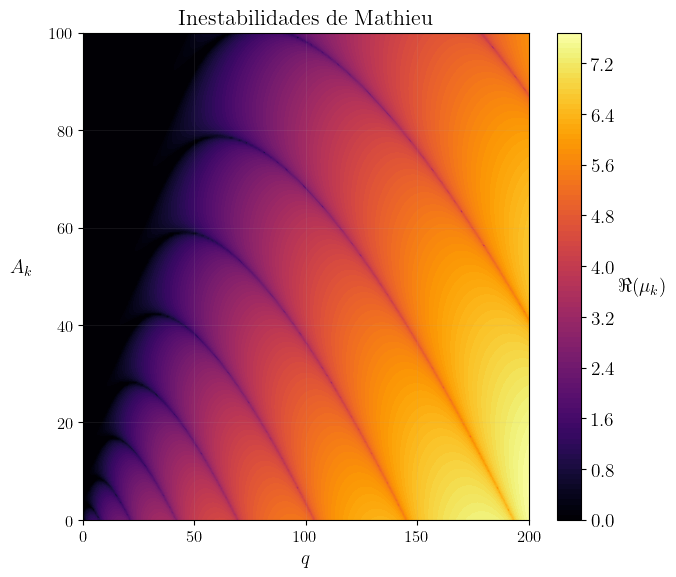

In [7]:
plt.figure(figsize=(7, 6))
contour = plt.contourf(q, Ak, np.real(mu), levels=100, cmap='inferno')
cbar = plt.colorbar(contour)
cbar.set_label(r'$\Re(\mu_k)$', fontsize=14, labelpad=20, rotation=0)

plt.title(r'Inestabilidades de Mathieu', fontsize=16)
plt.xlabel(r'$q$', fontsize=14)
plt.ylabel(r'$A_k$', fontsize=14, labelpad=20, rotation=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha = 0.1)
plt.tight_layout()
plt.show()

In [8]:
# Guardemos los resultados en un archivo CSV
save_csv(Aks, qs, mu, filename='mathieu_results2')

## Tipos de resonancias

### $q$ chicos (Narrow resonance)

La ecuación (2) nos decía

$$q = \frac{g^2}{4} \left( \frac{\phi_0}{m} \right)^2; \hspace{3cm} A_k = \left( \frac{k}{m} \right)^2 + 2 q; \hspace{3cm} T = m t + \frac{\pi}{2}$$

entonces, veamos para valores fijos de $q$ cómo es la resonancia para distintos modos.

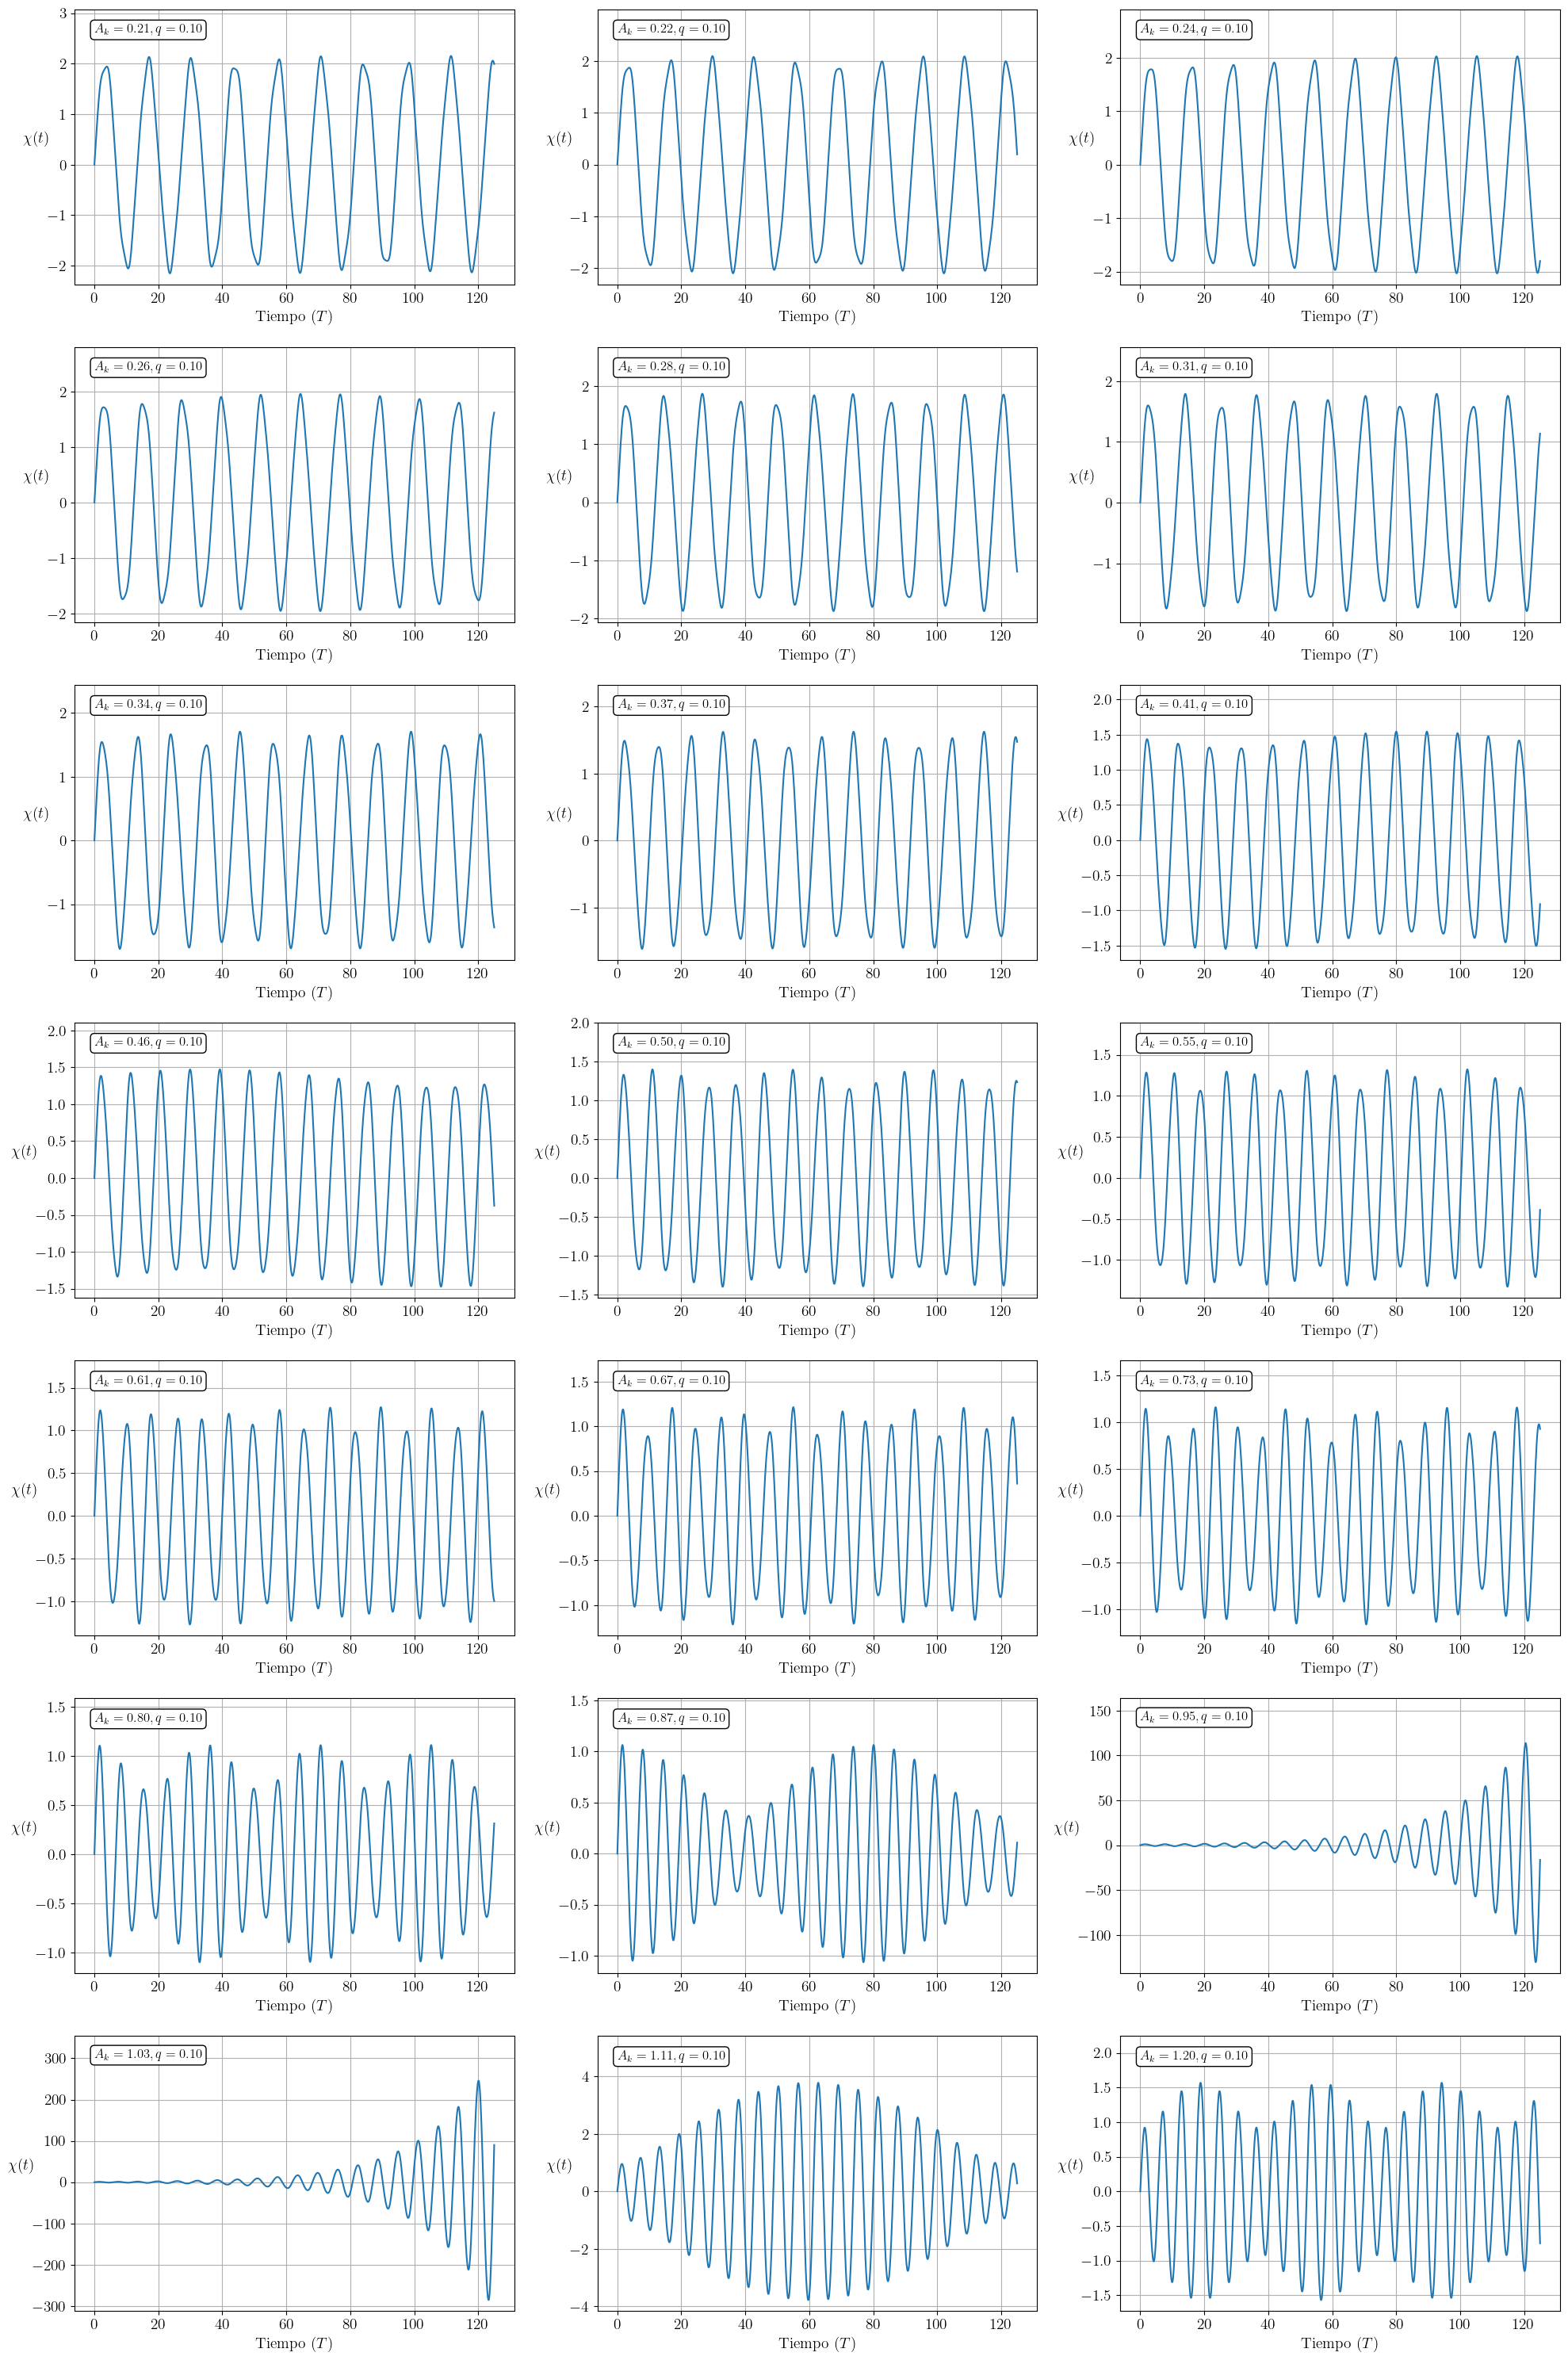

In [ ]:
km = np.linspace(1e-1, 1, 21)                           # Valores de k/m (modos)
u0, v0 = 0, 1                                           # Condiciones iniciales
T0, Tf = 0, 125                                         # Tiempos
q = 0.1                             

plt.figure(figsize=(20, 30))

for k in range(len(km)):
    Ak = km[k]**2 + 2 * q
    sol = solve_ivp(mathieu, [T0, Tf], [u0, v0], args=(Ak, q), rtol=1e-8, atol=1e-8)
    T, y, y_prime = sol.t, sol.y[0], sol.y[1]

    # Graficamos los resultados
    plt.subplot(7, 3, k + 1)
    plt.plot(T, y)
    plt.xlabel(r'Tiempo ($T$)')
    plt.ylabel(r'$\chi(t)$', labelpad=10, rotation='horizontal')
    ymin, ymax = plt.gca().get_ylim()
    plt.ylim(ymin, ymax*1.3)
    plt.text(x=T[0], y=ymax*1.1, s=rf'$A_k = {Ak:.2f}, q = {q:.2f}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    plt.grid()

plt.tight_layout()
plt.show()

### $q$ grande (Broad resonance)

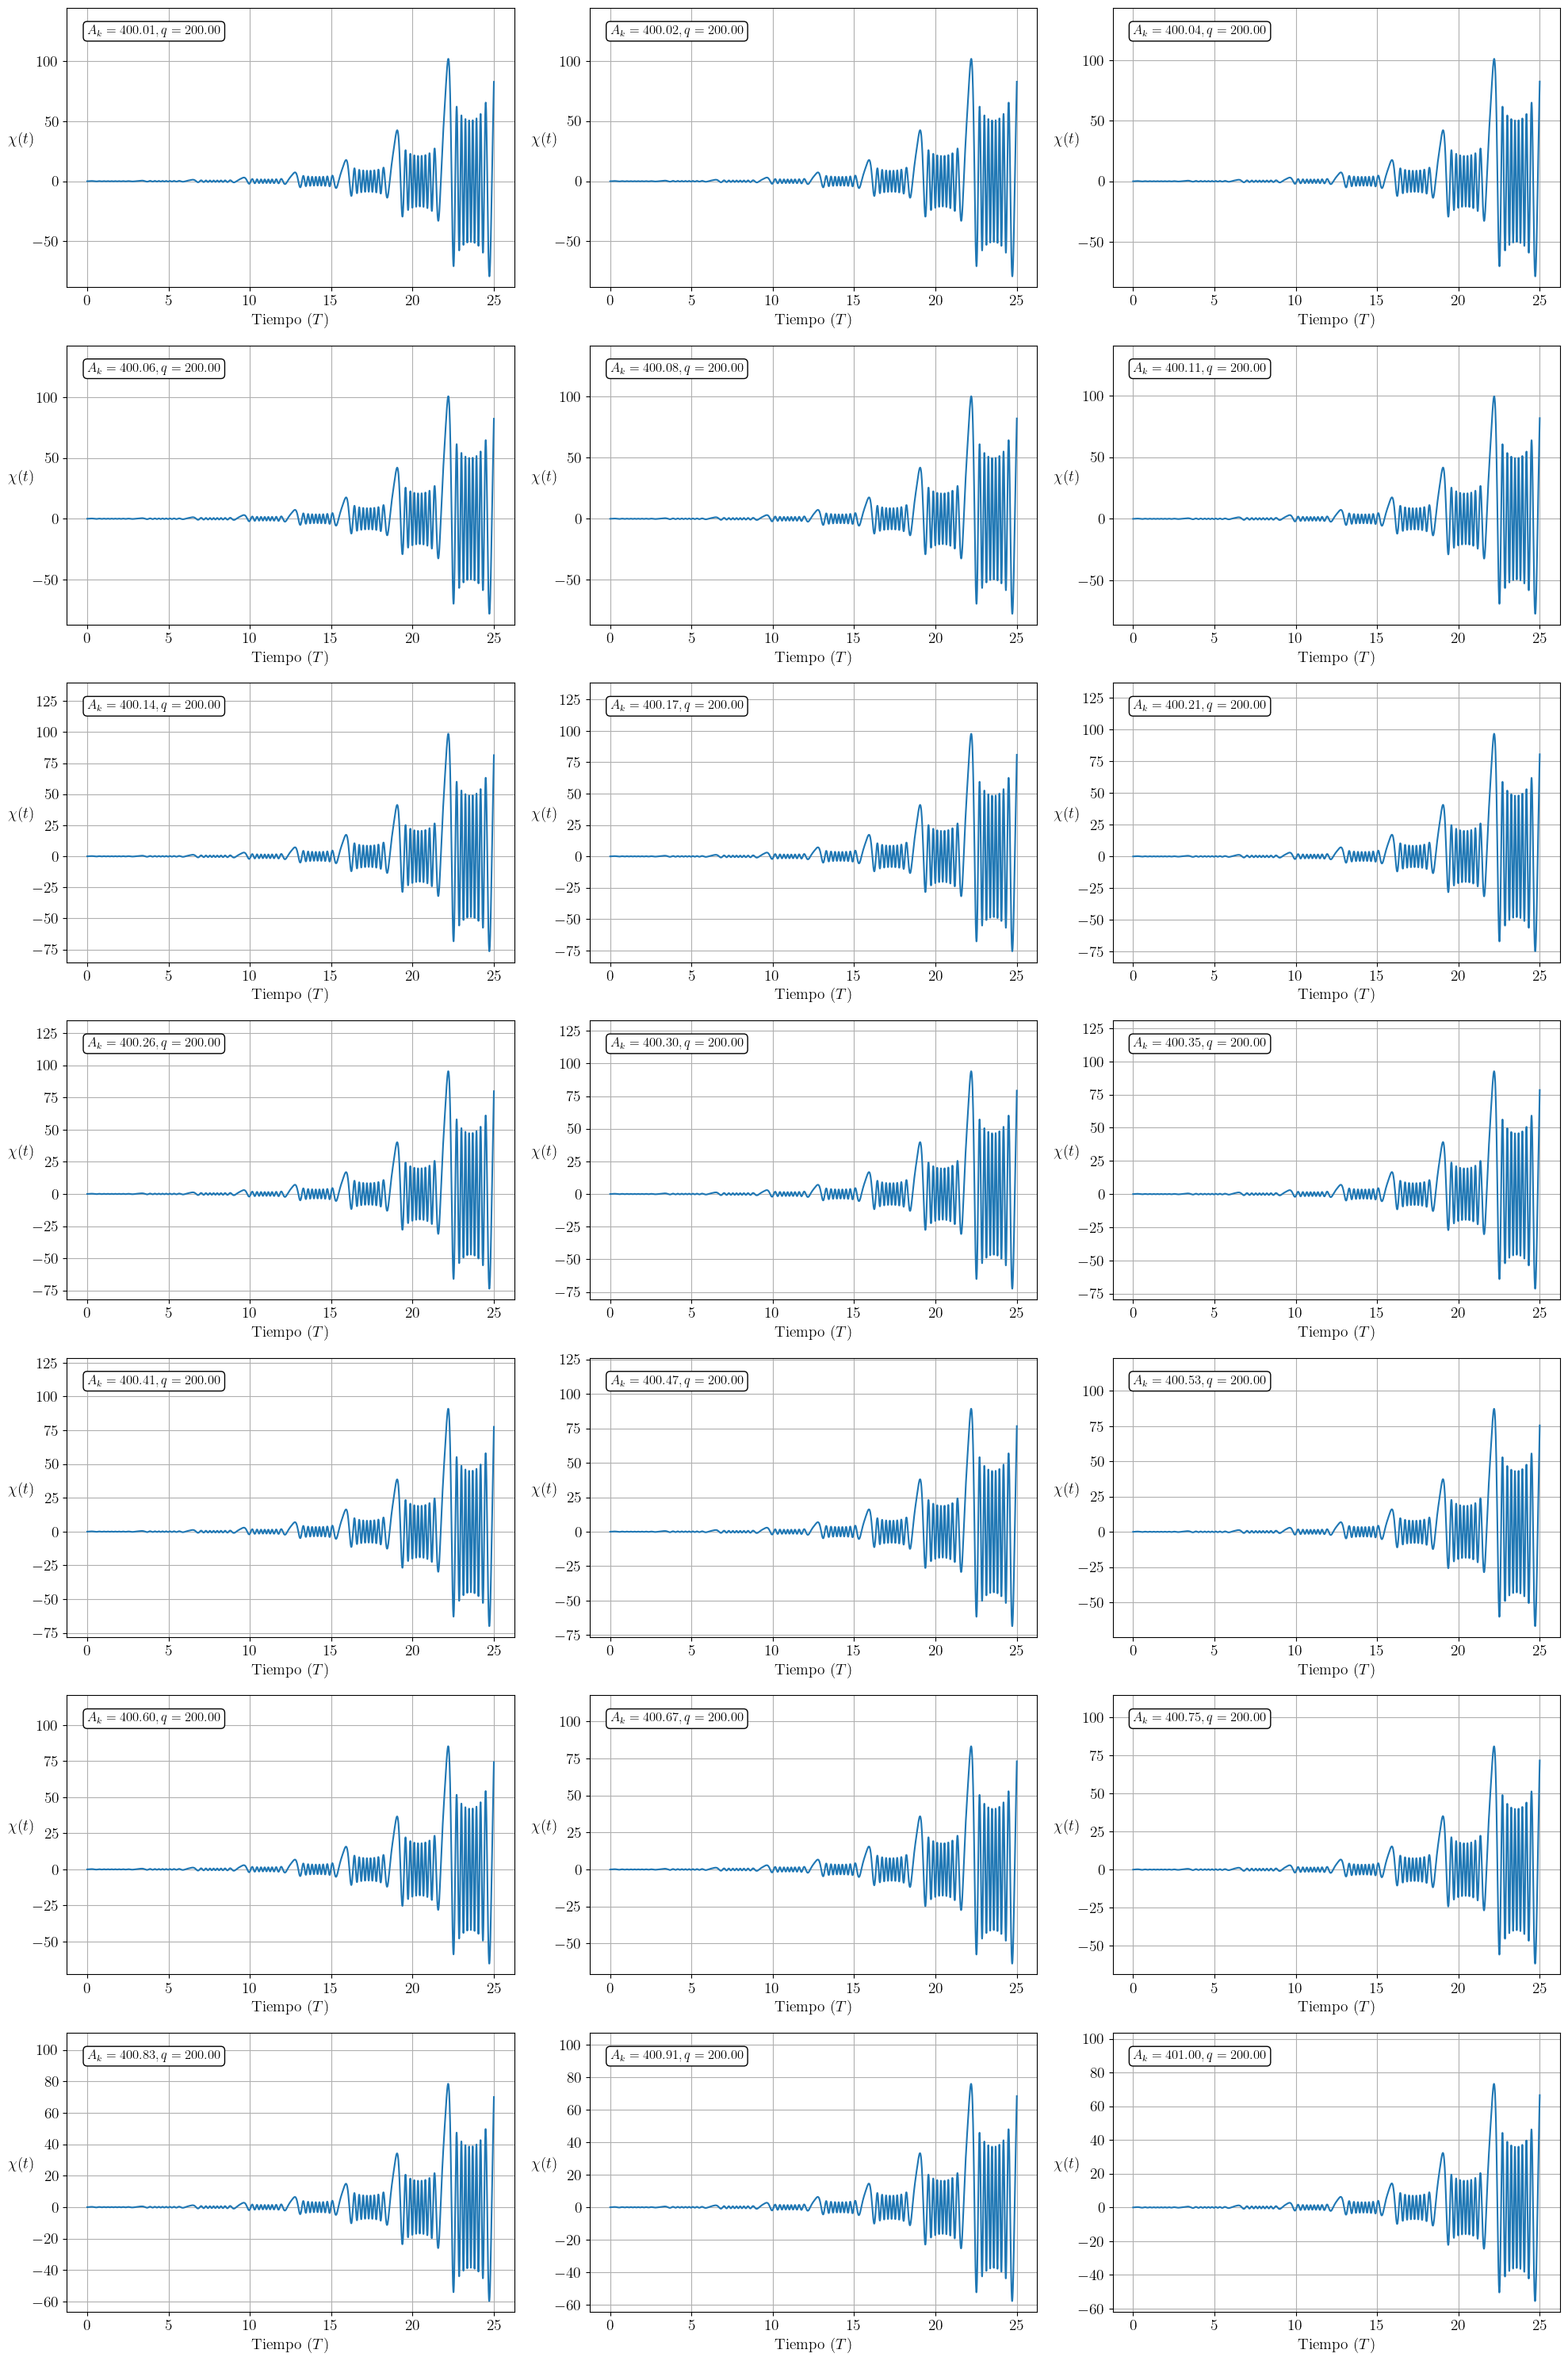

In [ ]:
km = np.linspace(1e-1, 1, 21)                           # Valores de k/m (modos)
u0, v0 = 0, 1                                           # Condiciones iniciales
T0, Tf = 0, 25                                          # Tiempos
q = 200                             

plt.figure(figsize=(20, 30))

for k in range(len(km)):
    Ak = km[k]**2 + 2 * q
    sol = solve_ivp(mathieu, [T0, Tf], [u0, v0], args=(Ak, q), rtol=1e-8, atol=1e-8)
    T, y, y_prime = sol.t, sol.y[0], sol.y[1]

    # Graficamos los resultados
    plt.subplot(7, 3, k + 1)
    plt.plot(T, y)
    plt.xlabel(r'Tiempo ($T$)')
    plt.ylabel(r'$\chi(t)$', labelpad=10, rotation='horizontal')
    ymin, ymax = plt.gca().get_ylim()
    plt.ylim(ymin, ymax*1.3)
    plt.text(x=T[0], y=ymax*1.1, s=rf'$A_k = {Ak:.2f}, q = {q:.2f}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    plt.grid()

plt.tight_layout()
plt.show()

## Número de partículas

El número de partículas del campo hijo estará dado por

$$n_\chi (k) = \frac{1}{2 \Omega_\chi} \left( \left| \frac{d \chi_k}{dT} \right|^2 + \Omega^2_\chi \left| \chi_k \right|^2 \right) - \frac{1}{2} \tag{10}$$

dónde

$$\Omega_\chi^2 (k, t) = \frac{k^2}{a^2} + g^2 \phi^2 (t) \tag{11}$$

Para el campo del inflatón recordemos que planteamos un potencial armónico entonces tenemos

$$\phi = \phi_0 \sin \left( T \right) \tag{12}$$

In [82]:
u0, v0 = 0, 1                                                                           # Condiciones iniciales
phi_0 = 1.0                                                                             # Amplitud del inflatón
a = 1                                                                                   # Factor de escala
g = 1                                                                                   # Constante de acoplamiento del inflatón
m = 1                                                                                   # Masa del campo hijo (supongo masa de Planck)

### Narrow resonance

Elijamos $q = 0.1$ y $A_k = 1.03$ de los cuadros de arriba y busquemos cómo es el número de partículas

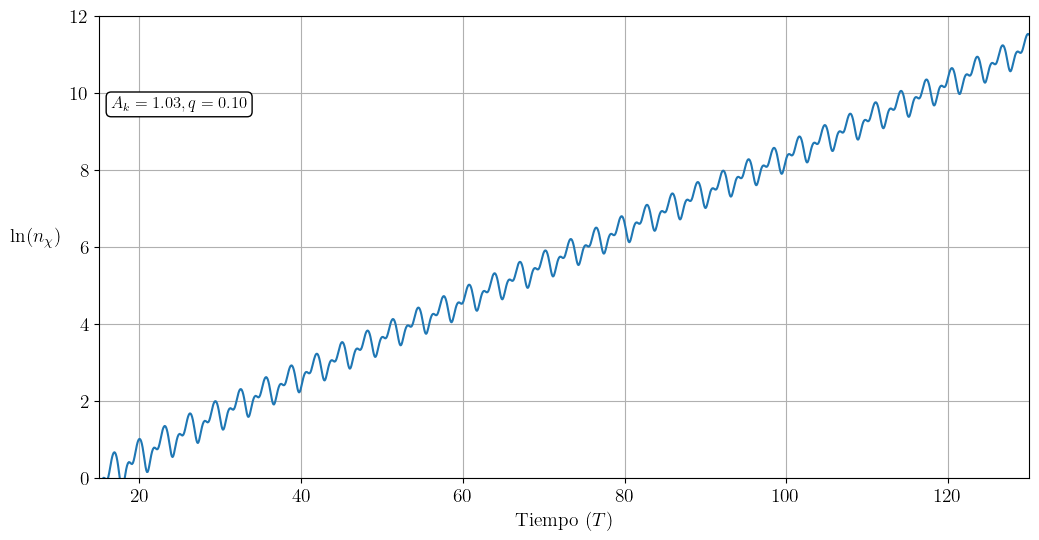

In [83]:
T0, Tf = 0, 130                                                                         # Tiempos
q = 0.1; Ak = 1.03
k = np.sqrt(Ak - 2 * q) * m

sol = solve_ivp(mathieu, [T0, Tf], [u0, v0], args=(Ak, q), rtol=1e-8, atol=1e-8)
T, y, y_prime = sol.t, sol.y[0], sol.y[1]

phi = phi_0 * np.sin(T)                                                                 # Potencial armónico del inflatón
Omega_chi = (k**2 / a**2) + (g**2 * phi**2)                                             # Frecuencia del campo hijo

n = 1 / (2 * Omega_chi) * (np.abs(y_prime)**2 + Omega_chi**2 * np.abs(y)**2) - 1/2      # Número de partículas del campo hijo

# Graficamos los resultados
plt.plot(T, np.log(np.abs(n)))
plt.xlabel(r'Tiempo ($T$)')
plt.ylabel(r'$\ln (n_\chi)$', labelpad=25, rotation='horizontal')
plt.xlim(15,130)
plt.ylim(0, 12)
ymin, ymax = plt.gca().get_ylim()
xmin, xmax = plt.gca().get_xlim()
plt.yscale('linear')
plt.text(x=1.1*xmin, y=ymax*0.8, s=rf'$A_k = {Ak:.2f}, q = {q:.2f}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.grid()

plt.show()

### Broad resonance

Elijamos $q = 200$ y $A_k = 401$ de los cuadros de arriba

/tmp/ipykernel_376628/171216465.py:14: RuntimeWarning: divide by zero encountered in log
  plt.plot(T, np.log(np.abs(n)))


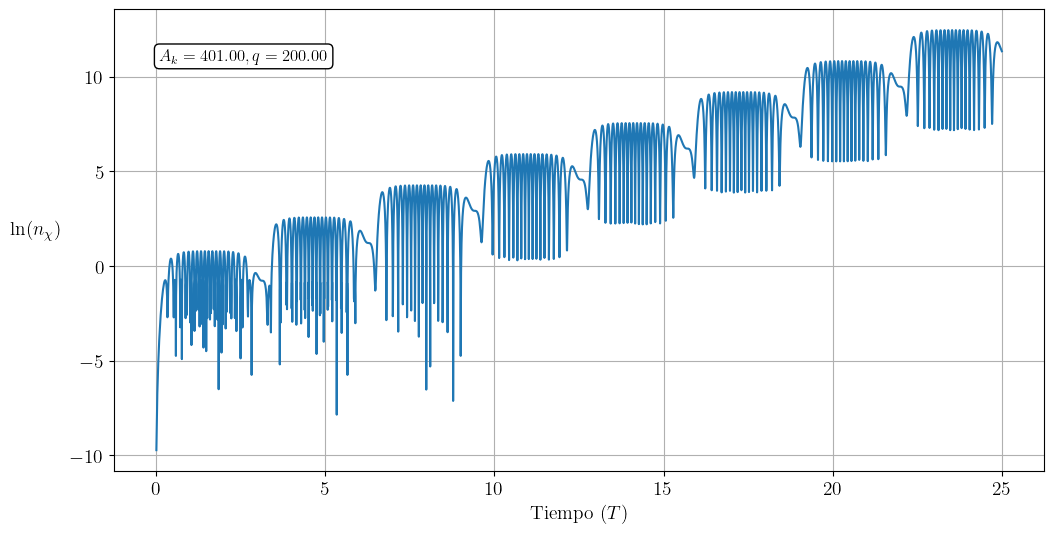

In [96]:
T0, Tf = 0, 25                                                                         # Tiempos
q = 200; Ak = 401
k = np.sqrt(Ak - 2 * q) * m

sol = solve_ivp(mathieu, [T0, Tf], [u0, v0], args=(Ak, q), rtol=1e-8, atol=1e-8)
T, y, y_prime = sol.t, sol.y[0], sol.y[1]

phi = phi_0 * np.sin(T)                                                                 # Potencial armónico del inflatón
Omega_chi = (k**2 / a**2) + (g**2 * phi**2)                                             # Frecuencia del campo hijo

n = 1 / (2 * Omega_chi) * (np.abs(y_prime)**2 + Omega_chi**2 * np.abs(y)**2) - 1/2      # Número de partículas del campo hijo

# Graficamos los resultados
plt.plot(T, np.log(np.abs(n)))
plt.xlabel(r'Tiempo ($T$)')
plt.ylabel(r'$\ln (n_\chi)$', labelpad=25, rotation='horizontal')
ymin, ymax = plt.gca().get_ylim()
xmin, xmax = plt.gca().get_xlim()
plt.yscale('linear')
plt.text(x=0.1, y=ymax*0.8, s=rf'$A_k = {Ak:.2f}, q = {q:.2f}$', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.grid()

plt.show()